# Data generation AR 1 process
This file generates data for a signal whose Fourier coefficients are modelled by an AR 1 process.

## Load packages and auxiliary functions

In [1]:
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Functions for sampling distributions

In [2]:
function updateAR(z_prev, gamma, theta)
    # all arguments are determinisitic

    # calculate update matrix
    A = [theta'; Ic(length(theta)-1) zeros(length(theta)-1,1)]
    
    # calculate process noise
    w = randomGaussian(float(0), float(1/sqrt(gamma)), 1)
    
    return A * z_prev + em(length(z_prev), 1)*w
end
;

In [3]:
function randomGamma(α::Float64, β::Float64, nr::Int)
    return squeeze(rand(Distributions.Gamma(α, 1/β), nr))[1]
end
;

In [4]:
function randomGaussian(μ::Array{Float64,1}, σ::Array{Float64,2}, nr::Int)
    return squeeze(rand(MvNormal(μ, σ), nr))
end
function randomGaussian(μ::Float64, σ::Float64, nr::Int)
    return squeeze(rand(Normal(μ, σ), nr))[1]
end
;

## Specify parameters

In [5]:
# signal characteristics
fs_desired = 8000                    # sampling frequency
T = 15                                # time duration

# probabilistic fourier parameters
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 1

# load model parameters (of process noise)
load_file = "../inferred_values/all_drilling_AR05_15freqs.h5" # file in which model parameters are present
;

## Load and generate parameters

In [6]:
# placeholder for parameters
params = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, 2*freq_bins)

# load parameters
for k = 1:2*freq_bins
    # load parameters of imaginary coefficients
    params[k] = h5read(load_file, "bin_"*string(k, pad=2))     
    if AR_order == 1
        params[k]["mean_theta"] = squeeze(rand(AR_order))[1]
        params[k]["cov_theta"] = squeeze(rand(AR_order, AR_order))[1]
    else
        params[k]["mean_theta"] = squeeze(rand(AR_order))
        params[k]["cov_theta"] = squeeze(rand(AR_order, AR_order))
    end
end
;

## Generate data

In [7]:
t = 0:1/fs_desired:T
x_mem = Float64[]
z_mem = Array{Float64,1}[]

# priors on z
z = Array{Array{Float64, 1}}(undef, 2*freq_bins)
for f = 1:2*freq_bins
    z[f] = zeros(AR_order)
end

# generate samples
for k = 1:length(t)
    
    # update z[f]
    for f = 1:2*freq_bins
        gamma = randomGamma(params[f]["a_gamma"], params[f]["b_gamma"], 1)
        theta = randomGaussian(params[f]["mean_theta"], params[f]["cov_theta"], 1)
        z[f] = updateAR(z[f], gamma, theta)
    end

    # calc c matrix
    C = calc_C(freq, [t[k]])
    
    # calc x
    x = 0
    for f = 1:2*freq_bins
        x = x + z[f][1] * C[f]
    end
    
    push!(x_mem, x)
    push!(z_mem, [z[f][1] for f = 1:2*freq_bins])
end

## plot data

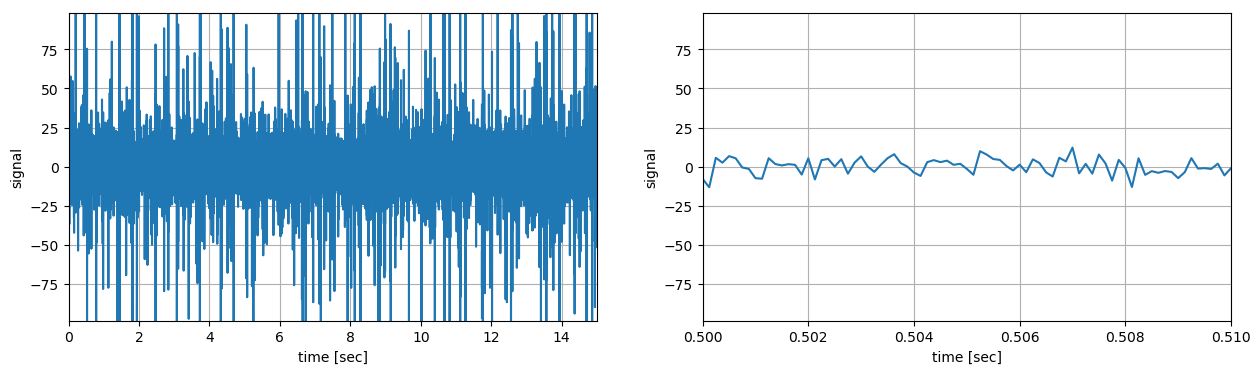

In [8]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, x_mem)
ax[1].set_ylim(-3*std(x_mem), 3*std(x_mem))
ax[1].grid()
ax[1].set_xlim(t[1], t[end])
ax[1].set_xlabel("time [sec]")
ax[1].set_ylabel("signal")
ax[2].plot(t, x_mem)
ax[2].set_ylim(-3*std(x_mem), 3*std(x_mem))
ax[2].grid()
ax[2].set_xlim(0.5, 0.51)
ax[2].set_xlabel("time [sec]")
ax[2].set_ylabel("signal")
;